In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="MIG-0bb056ed-239d-5614-a667-fd108c1880cf" 
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
device = "cuda:0"

In [4]:
from br.chandrasekaran_et_al.main import get_metadata

path = '/allen/aics/assay-dev/users/Alex/replearn/rep_paper/benchmarking_representations/notebooks/npm1_perturb_embeds_global/'
models = ['CNN_sdf_noalign_global', 'CNN_sdf_SO3_global', 'CNN_seg_noalign_global', 'CNN_seg_SO3_global', 'vn_so3']

/home/ritvik.vasan/anaconda3/envs/replearn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import pandas as pd
orig = pd.read_csv('/allen/aics/assay-dev/users/Alex/replearn/rep_paper/data/npm1_perturb_classical_manifest.csv')

In [6]:
import pandas as pd
all_ret = []
for m in models:
    df = pd.read_csv(path + m +'.csv')
    df['model'] = m
    all_ret.append(df)
df = pd.concat(all_ret, axis=0).reset_index(drop=True)

In [7]:
all_ret = df.merge(orig[['CellId', 'condition_coarse_int', 'condition_coarse', 'condition']], on='CellId')

# dummy cols
all_ret['well_position'] = 'A0'
all_ret['Assay_Plate_Barcode'] = 'Plate0'

In [8]:
import pandas as pd
from tqdm import tqdm
from br.chandrasekaran_et_al import utils

def get_featurecols(df):
    """returna  list of featuredata columns"""
    return [c for c in df.columns if 'mu' in c]

def get_featuredata(df):
    """return dataframe of just featuredata columns"""
    return df[get_featurecols(df)]

cols = [i for i in all_ret.columns if "mu" in i]

replicate_feature = "Metadata_broad_sample"
batch_size = 100000
null_size = 100000


all_rep = []
all_match = []
all_fr = []
for model in tqdm(all_ret['model'].unique(), total=len(all_ret['model'].unique())):
    df_feats = all_ret.loc[all_ret['model'] == model].reset_index(drop=True)
    df_feats['Metadata_ObjectNumber'] = df_feats['CellId']

    import pycytominer
    all_normalized_df = []
    cols = [i for i in df_feats.columns if "mu" in i] 
    for plate in df_feats['Assay_Plate_Barcode'].unique():
        test = df_feats.loc[df_feats['Assay_Plate_Barcode'] == plate].reset_index(drop=True)
        # test = test.groupby(['condition_coarse']).mean().reset_index()
        # test['Assay_Plate_Barcode'] = 'plate0'
        # test['well_position'] = 'a0'
        normalized_df = pycytominer.normalize(
            profiles=test,
            features=cols,
            meta_features=['Assay_Plate_Barcode', 'well_position', 'condition_coarse', 'condition'],
            method="standardize",
            mad_robustize_epsilon=0,
            samples="all"
        )
        normalized_df = pycytominer.normalize(
            profiles=normalized_df,
            features=cols,
            meta_features=['Assay_Plate_Barcode', 'well_position', 'condition_coarse', 'condition'],
            method="standardize",
            samples="condition == 'DMSO (control)'",
        )
        
        all_normalized_df.append(normalized_df)
    df_final = pd.concat(all_normalized_df, axis=0).reset_index(drop=True)

    vals = []
    for ind, row in df_final.iterrows():
        if row['condition'] == 'DMSO (control)':
            vals.append('negcon')
        else:
            vals.append(None)

    # more dummy cols 
    df_final['Metadata_control_type'] = vals
    df_final['Metadata_broad_sample'] = df_final['condition']
    df_final['Cell_type'] = 'hIPSc'
    df_final['Perturbation'] = 'compound'
    df_final['Time'] = '1'
    df_final['Metadata_target_list'] = 'none'
    df_final['target_list'] = 'none'
    df_final['Metadata_Plate'] = 'Plate0'

    experiment_df = df_final
    
    replicability_map_df = pd.DataFrame()
    replicability_fr_df = pd.DataFrame()
    matching_map_df = pd.DataFrame()
    matching_fr_df = pd.DataFrame()
    gene_compound_matching_map_df = pd.DataFrame()
    gene_compound_matching_fr_df = pd.DataFrame()

    replicate_feature = 'Metadata_broad_sample'
    for cell in experiment_df.Cell_type.unique():
        cell_df = experiment_df.query("Cell_type==@cell")
        modality_1_perturbation = "compound"
        modality_1_experiments_df = cell_df.query("Perturbation==@modality_1_perturbation")
        for modality_1_timepoint in modality_1_experiments_df.Time.unique():
            modality_1_timepoint_df = modality_1_experiments_df.query(
                "Time==@modality_1_timepoint"
            )
            modality_1_df = pd.DataFrame()
            for plate in modality_1_timepoint_df.Assay_Plate_Barcode.unique():
                data_df = df_final.loc[df_final['Assay_Plate_Barcode'].isin([plate])]
                data_df = data_df.drop(columns=['Metadata_target_list','target_list']).reset_index(drop=True)
                # data_df = data_df.groupby(['pert_iname']).sample(n=10).reset_index(drop=True)
                modality_1_df = utils.concat_profiles(modality_1_df, data_df)
            
            # Set Metadata_broad_sample value to "DMSO" for DMSO wells
            modality_1_df[replicate_feature].fillna("DMSO", inplace=True)
            print(modality_1_df.shape)

            # Remove empty wells
            modality_1_df = utils.remove_empty_wells(modality_1_df)
            print('remove empty', modality_1_df.shape)

            # Description
            description = f"{modality_1_perturbation}_{cell}_{utils.time_point(modality_1_perturbation, modality_1_timepoint)}"

            modality_1_df["Metadata_negcon"] = np.where(
                modality_1_df["Metadata_control_type"] == "negcon", 1, 0
            )  # Create dummy column

            pos_sameby = ["Metadata_broad_sample"]
            pos_diffby = []
            neg_sameby = ["Metadata_Plate"]
            neg_diffby = ["Metadata_negcon"]

            metadata_df = utils.get_metadata(modality_1_df)
            feature_df = get_featuredata(modality_1_df)
            feature_values = feature_df.values

            result = utils.run_pipeline(
                metadata_df,
                feature_values,
                pos_sameby,
                pos_diffby,
                neg_sameby,
                neg_diffby,
                anti_match=False,
                batch_size=batch_size,
                null_size=null_size,
            )
            result = result.query("Metadata_negcon==0").reset_index(drop=True)

            qthreshold = 0.001

            replicability_map_df, replicability_fr_df = utils.create_replicability_df(
                replicability_map_df,
                replicability_fr_df,
                result,
                pos_sameby,
                qthreshold,
                modality_1_perturbation,
                cell,
                modality_1_timepoint,
            )
    replicability_map_df['model'] = model
    matching_map_df['model'] = model
    replicability_fr_df['model'] = model
    all_rep.append(replicability_map_df)
    all_match.append(matching_map_df)
    all_fr.append(replicability_fr_df)

  0%|          | 0/5 [00:00<?, ?it/s]

(1025, 522)
remove empty (1025, 522)


 20%|██        | 1/5 [00:14<00:59, 14.89s/it]

(1025, 522)
remove empty (1025, 522)


 40%|████      | 2/5 [00:29<00:44, 14.77s/it]

(1025, 522)
remove empty (1025, 522)


 60%|██████    | 3/5 [00:44<00:29, 14.86s/it]

(1025, 522)
remove empty (1025, 522)


 80%|████████  | 4/5 [00:59<00:15, 15.07s/it]

(1025, 522)
remove empty (1025, 522)


100%|██████████| 5/5 [01:15<00:00, 15.03s/it]


In [9]:
all_rep = pd.concat(all_rep, axis=0).reset_index(drop=True)
all_fr = pd.concat(all_fr, axis=0).reset_index(drop=True)

all_fr['metric'] = 'Fraction retrieved'
all_fr['value'] = all_fr['fr']
all_rep['metric'] = 'Mean average precision'
all_rep['value'] = all_rep['mean_average_precision']
metrics = pd.concat([all_fr, all_rep], axis=0).reset_index(drop=True)

plot_df = metrics.loc[metrics['metric'] == 'Fraction retrieved'].reset_index(drop=True)

In [10]:
rep_dict = {'CNN_sdf_noalign_global': 'SDF classical', 'CNN_sdf_SO3_global': 'SO3 SDF', 
           'CNN_seg_noalign_global': 'Seg classical', 'CNN_seg_SO3_global': 'SO3 seg', 
           'vn_so3': 'SO3 point cloud'}
metrics['model'] = metrics['model'].replace(rep_dict)

print('q threshold', 0.05)
all_m = []
for model in metrics['model'].unique():
    this_m = metrics.loc[metrics['model'] == model].reset_index(drop=True)
    this_m= this_m.loc[this_m['q_value'] < 0.05].reset_index(drop=True)
    print('Model', model)
    drugs = [i for i in this_m.loc[this_m['above_q_threshold'] == True]['Metadata_broad_sample'].unique()]
    print('Retrieved drugs', len(drugs), drugs)
    all_m.append(this_m)

q threshold 0.05
Model SDF classical
Retrieved drugs 6 ['Actinomyocin D 0.5ug per mL', 'Jasplakinolide 50 nM (E5)', 'Nocodazole 0.1uM (E4)', 'Paclitaxel 5uM (E2)', 'Staurosporine 1uM (E8)', 'Torin 1uM']
Model SO3 SDF
Retrieved drugs 7 ['Actinomyocin D 0.5ug per mL', 'Jasplakinolide 50 nM (E5)', 'Nocodazole 0.1uM (E4)', 'Paclitaxel 5uM (E2)', 'Roscovitine 10uM (E9)', 'Staurosporine 1uM (E8)', 'Torin 1uM']
Model Seg classical
Retrieved drugs 0 []
Model SO3 seg
Retrieved drugs 2 ['Actinomyocin D 0.5ug per mL', 'Staurosporine 1uM (E8)']
Model SO3 point cloud
Retrieved drugs 7 ['Actinomyocin D 0.5ug per mL', 'Jasplakinolide 50 nM (E5)', 'Nocodazole 0.1uM (E4)', 'Paclitaxel 5uM (E2)', 'Roscovitine 10uM (E9)', 'Staurosporine 1uM (E8)', 'Torin 1uM']


In [13]:
all_rep

,Metadata_broad_sample,mean_average_precision,nlog10pvalue,q_value,nlog10qvalue,above_p_threshold,above_q_threshold,Description,Modality,Cell,time,timepoint,model,metric,value
0,Actinomyocin D 0.5ug per mL,0.780168,4.473802,0.000571,3.243353,True,True,compound_hIPSc_long,compound,hIPSc,long,1,CNN_sdf_noalign_global,Mean average precision,0.780168
1,BIX 1uM,0.423916,0.971812,0.148152,0.829292,False,False,compound_hIPSc_long,compound,hIPSc,long,1,CNN_sdf_noalign_global,Mean average precision,0.423916
2,Bafilomycin A1 0.1uM,0.199918,0.972838,0.148152,0.829292,False,False,compound_hIPSc_long,compound,hIPSc,long,1,CNN_sdf_noalign_global,Mean average precision,0.199918
3,Brefeldin 5uM,0.113906,0.496779,0.318582,0.496779,False,False,compound_hIPSc_long,compound,hIPSc,long,1,CNN_sdf_noalign_global,Mean average precision,0.113906
4,Chloroquin 40uM,0.141014,0.744509,0.218682,0.660188,False,False,compound_hIPSc_long,compound,hIPSc,long,1,CNN_sdf_noalign_global,Mean average precision,0.141014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,Roscovitine 10uM (E9),0.440590,2.497708,0.007720,2.112357,True,True,compound_hIPSc_long,compound,hIPSc,long,1,vn_so3,Mean average precision,0.440590
81,Roscovitine 5uM (E10),0.316811,0.881351,0.177280,0.751340,False,False,compound_hIPSc_long,compound,hIPSc,long,1,vn_so3,Mean average precision,0.316811
82,Rotenone 0.5uM (E6),0.279243,0.400473,0.397674,0.400473,False,False,compound_hIPSc_long,compound,hIPSc,long,1,vn_so3,Mean average precision,0.279243
83,Staurosporine 1uM (E8),0.317054,2.820515,0.005140,2.289037,True,True,compound_hIPSc_long,compound,hIPSc,long,1,vn_so3,Mean average precision,0.317054


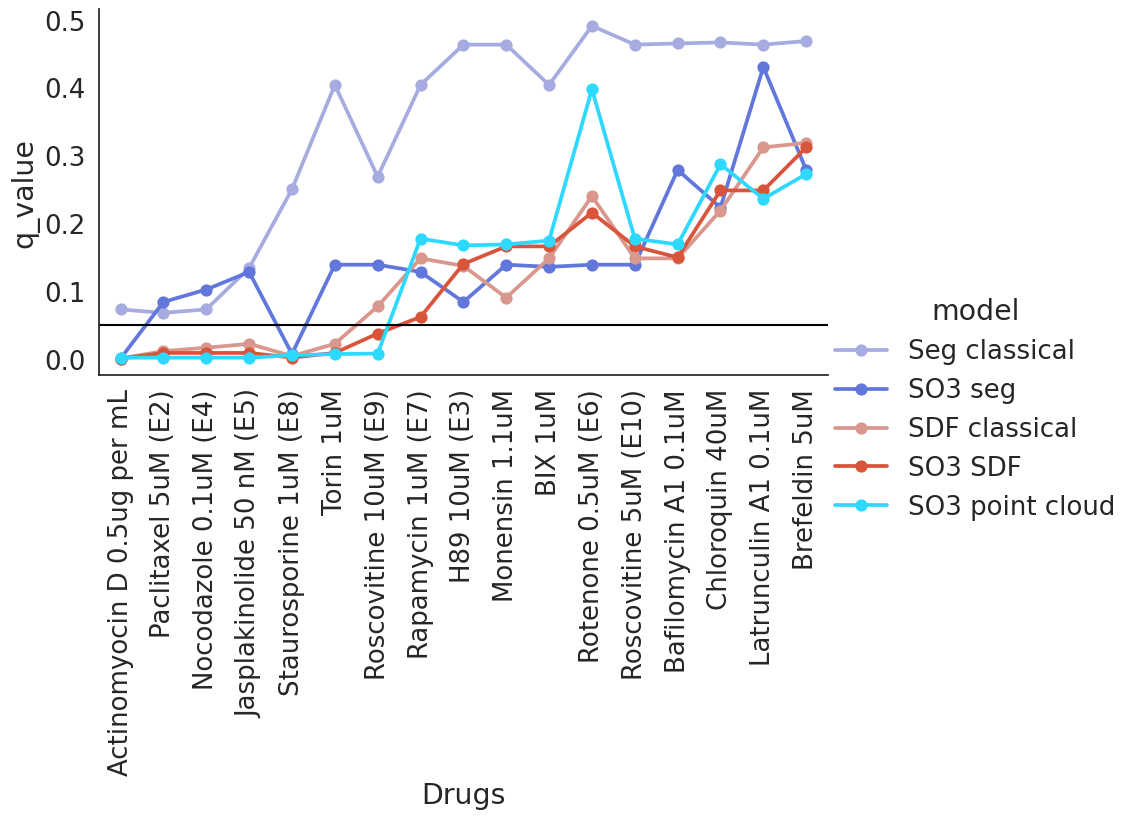

In [19]:
import seaborn as sns
sns.set_context('talk')
sns.set(font_scale=1.7)
sns.set_style('white')
rep_dict = {'CNN_sdf_noalign_global': 'SDF classical', 'CNN_sdf_SO3_global': 'SO3 SDF', 
           'CNN_seg_noalign_global': 'Seg classical', 'CNN_seg_SO3_global': 'SO3 seg', 
           'vn_so3': 'SO3 point cloud'}
all_rep['model'] = all_rep['model'].replace(rep_dict)
test = all_rep.sort_values(by='q_value').reset_index(drop=True)
test['Drugs'] = test['Metadata_broad_sample']
g = sns.catplot(data=test, x='Drugs', y='q_value', hue='model', kind='point', 
                               hue_order=['Seg classical', 'SO3 seg', 
                                  'SDF classical', 'SO3 SDF', 'SO3 point cloud'],
               palette=['#A6ACE0', '#6277DB', '#D9978E','#D8553B', '#2ED9FF'], aspect=2, height=5)
g.set_xticklabels(rotation=90)
plt.axhline(y=0.05, color='black') 
#g.savefig('./drug_dataset/q_values.pdf', dpi=300, bbox_inches='tight')